# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

TO-DO liste

1.INITIALISATION


2.FILTRAGE (paramètres fixes)
Fixer à la main les paramètres sans s'occuper de l'initialisation


3.PREDICTION (paramètres fixes)

4.PMCMC (paramètres refités à chaque nouvelle prédiction)
    




In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

In [2]:
import pymc
from pymc import MCMC

### Parameters

In [3]:
n0=365 #Initialisaion sample
M=10**5 #number of particles
n_pred=48  #number of predictions
N_daytype=8  #number of day types
burnin_halfhour=1000  #burnin period in 30min interval [OPTION C]
burnin_days=28 #burnin period in # of days  [OPTION C]

In [4]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5
    R=sum((M*w_h).astype(int))
    if R>M:
        return(print("weights are too heavy"))
    z=np.zeros(M)
    z[:R-1]=x_h[:R-1]
    w_=(M*w_h-(M*w_h).astype(int))/(M-R-1)
    z[R:]=sum(w_)
    return(z)

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [5]:
#test the functions on random sample
#resid_resample(npr.normal(size=10),np.repeat(0.1,10))

In [6]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([ 0.11162263,  0.52753274, -0.72012223,  1.63830957,  0.99339271,
        0.36540244,  2.62614791,  0.7173491 ,  0.54045076,  2.43075694])

### Simulate temperatures for T_heat

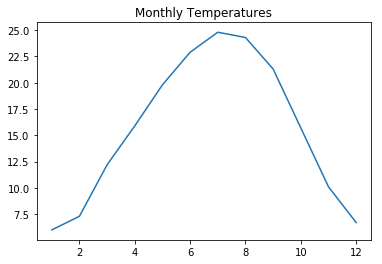

In [7]:
temp_month=np.array([6,7.3,12.2,15.9,19.8,22.9,24.8,24.3,21.3,15.7,10.1,6.7])  #monthly max temp in Paris
month=['jan','fev','mar','av','may','juin','juil','aou','sep','oct','nov','dec']
days_month=np.array([31,29,31,30,31,30,31,31,30,31,30,31])
i=0
temp_={}
for m in month:
    temp_[m]=np.repeat(temp_month[i],days_month[i])
    i=i+1
temp_month_mean=np.ones(0)
for m in month:
    temp_month_mean=np.concatenate((temp_month_mean,temp_[m]),axis=0)

plt.plot(range(1,13),temp_month)
plt.title('Monthly Temperatures')
plt.show()

In [8]:
T_h=np.copy(temp_month_mean)
T_h.shape

(366,)

### Load the data

In [9]:
path_AG="data/"
df=pd.read_csv(path_AG+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df.index=range(0,len(df))

In [10]:
df.head()

,Unnamed: 0,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype0,daytype1,daytype2,daytype3,daytype4,daytype6,daytype5,daytype7,daytype8,daytype
0,0,2009-06-06T06:00:00+02:00,2009-06-06,06:00,35984,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
1,1,2009-06-06T09:00:00+02:00,2009-06-06,09:00,43188,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
2,2,2009-06-06T11:30:00+02:00,2009-06-06,11:30,46959,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
3,3,2009-06-06T12:30:00+02:00,2009-06-06,12:30,48622,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
4,4,2009-06-06T20:30:00+02:00,2009-06-06,20:30,42578,DÃ©finitive,False,False,True,False,False,False,False,False,False,2


In [11]:
df=df.sort_values(by=['Date'])
df.index=range(0,len(df))
#Valeurs intermédiaires à partir de 2017

In [12]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]

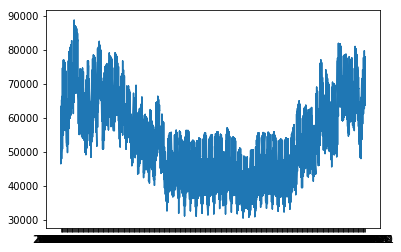

In [13]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

In [14]:
#try a different approach: consider 2pm daily time series
df_day=df[df.Heure=='14:00']
y_n=df_day['Consommation (MW)']
y_n=y_n[:burnin_days]

In [15]:
#y_n=df['Consommation (MW)']
#y_n=y_n[:burning_period]
#y_n=y_n.values

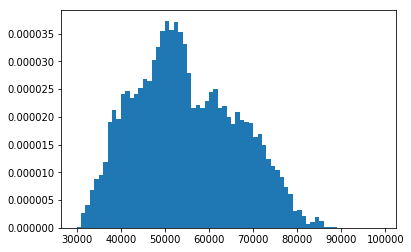

In [16]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

In [17]:
for k in range(0,9):
    df['daytype'+str(k)] = df['daytype'+str(k)].apply(lambda x:k if x==True else 0)


## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

In [177]:
#Least interesting approach since x values are invariant with the M particules at time n=0
s=10000*np.ones(M)
g_h=-10000*np.ones(M)
sigma2=10**15*np.ones(M)
sigma2_g_star=10**15*np.ones(M)
sigma2_s_star=10**15*np.ones(M)
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]
u_h=14 #mean of N(14,1)

### Option B: generate initial parameters based on prior distribution

In [182]:
sigma2=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
g_h = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)

u_h=npr.normal(14,1)  #fixed parameter, invariant to time
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2631: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2631: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


#### --> Calculate x and w at initial state based on initial parameters

In [183]:
#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

#Calculate x0 and w0 before filtering
x_season[0,:]=k_day[daytype]*s
if T_h[day]-u_h >0:
    x_heat[0,:]=g_h*(T_h[day]-u_h)*1
else:
    x_heat[0,:]=np.zeros(M)

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now
w0=x_0+npr.normal(0,sigma2,size=M)  #compute w_wave = g(y_0 l X_0)

### Option C: MCMC using MHA or Gibbs (TBA)

In [18]:
import numpy as np
from scipy.stats import truncnorm, invgamma
import math

In [19]:
df[df['Heure']=='14:00'][['Date', 'Consommation (MW)', 'daytype']][:30]

,Date,Consommation (MW),daytype
140343,2016-01-02,58683,8
140363,2016-01-03,59405,3
140439,2016-01-04,68302,0
140453,2016-01-05,70715,0
140507,2016-01-06,71359,1
140578,2016-01-07,70644,1
140632,2016-01-08,69590,1
140679,2016-01-09,61488,2
140725,2016-01-10,60109,3
140740,2016-01-11,71046,0


In [20]:
consumption = list(df[df['Heure']=='14:00']['Consommation (MW)'][:30])
temperature_ts = [5]*30 #france mean temp in jan 2016
daytype_ts = list(df[df['Heure']=='14:00']['daytype'][:30])

In [21]:
#daytype_ts

[8,
 3,
 0,
 0,
 1,
 1,
 1,
 2,
 3,
 0,
 0,
 1,
 1,
 1,
 2,
 3,
 0,
 0,
 1,
 1,
 1,
 2,
 3,
 0,
 0,
 1,
 1,
 1,
 2,
 3]

In [42]:
def pf_init_gibbs(temperature_ts, daytype_ts, elec_ts, nb_init, nb_particles, sigma2, kappa, u_heat):
    # Variables initialization
    s = np.zeros((nb_init, nb_particles)) 
    g_heat = np.zeros((nb_init, nb_particles))
    #sigma_s and sigma_g are fixed
    sigma_s_star_2 = np.zeros((1, nb_particles)) 
    sigma_g_star_2 = np.zeros((1, nb_particles))

    #Gibbs : Initialization
    s[0,0] = truncnorm.rvs(a = 0,b = math.inf, loc= 0, scale = 10**4, size=1)[0]#scale = 10**8
    g_heat[0,0] =  truncnorm.rvs(a = - math.inf,b = 0, loc= 0, scale = 10**4, size=1)[0]#scale = 10**8
    sigma_s_star_2[0, 0] = invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
    sigma_g_star_2[0, 0] = invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
    
    #Gibbs : Step 0
    sigma_s_star0 = math.sqrt(sigma_s_star_2[0,0])
    sigma_g_star0 = math.sqrt(sigma_g_star_2[0,0])
    for i in range(1, nb_init):
        s[i,0] = s[i-1,0] + truncnorm.rvs(a = -s[i-1,0],b = math.inf, loc= 0, scale = sigma_s_star0, size=1)[0] #page 18
        g_heat[i,0] = g_heat[i-1,0] + truncnorm.rvs(a = -math.inf, b=- g_heat[i-1,0], loc= 0, scale = sigma_g_star0, size=1)[0]
    
    #Gibbs : step t > 0
    for j in range(1, nb_particles):
        print("Particle " + str(j) + "/" + str(nb_particles))
        s[:,j] = s[:,j-1]
        g_heat[:,j] = g_heat[:,j-1]
        sigma_s_star_2[:,j] = sigma_s_star_2[:,j-1]
        sigma_g_star_2[:,j] = sigma_g_star_2[:,j-1]
        
        # Simulate s0
        #Compute variance and mean denominator
        denom_s_0 = (10**4)*sigma_s_star_2[0, j]*(kappa[daytype_ts[0]]**2) + sigma2*sigma_s_star_2[0, j] + (10**8)*sigma2 
        #Compute mean numerator
        numerator_mean_s_0 = (10**4)*sigma2* s[1,j] + (10**8)*sigma_s_star_2[0, j]*kappa[daytype_ts[0]]*elec_ts[0]
        if (u_heat > temperature_ts[0]):
            numerator_mean_s_0 -= (10**4)*sigma_s_star_2[0, j]*kappa[daytype_ts[0]]*g_heat[0,j]*(temperature_ts[0] - u_heat)
        #Compute the final parameters of the truncated normal that simulates from the full conditional of s_0
        #Mean
        mean_s_0 = numerator_mean_s_0 / denom_s_0
        #Variance
        var_s_0 = ((10**4) *sigma2*sigma_s_star_2[0, j]) / denom_s_0#scale = 10**8

        while True:
            s[0,j] = truncnorm.rvs(a = 0, b = math.inf, loc= mean_s_0, scale = math.sqrt(var_s_0), size=1)[0]
            if(s[0,j]!=math.inf):
                break
        print("s[0,"+str(j)+"]")
        print(s[0,j])
        
        # Simulate s(i), i>0
        for i in range(1, nb_init):
            denom_s_i = 2*sigma2 + sigma_s_star_2[0, j]*(kappa[daytype_ts[i]]**2)
            dependence_next_s = 0
            if (i+1 < nb_init-1):
                dependence_next_s = s[i+1,j]
            #Compute mean numerator
            numerator_mean_s_i = sigma2*(s[i-1,j] + dependence_next_s) + sigma_s_star_2[0, j]*kappa[daytype_ts[i]]*(elec_ts[i])
            if (u_heat > temperature_ts[i]):
                numerator_mean_s_i = numerator_mean_s_i - sigma_s_star_2[0, j]*kappa[daytype_ts[i]]*g_heat[i,j]*(temperature_ts[i] - u_heat)
            mean_s_i = numerator_mean_s_i / denom_s_i
            var_s_i = (sigma2*sigma_s_star_2[0, j]) / denom_s_i
            
            a=0
            while True:
                s[i,j] = truncnorm.rvs(a = 0, b = math.inf, loc= mean_s_i, scale = math.sqrt(var_s_i), size=1)[0]
                if(s[i,j]!=math.inf and s[i,j]!=-math.inf):
                    break
                a=a+1
                if(a%5==0):
                    print(a)
            print("s["+str(i)+","+str(j)+"]")
            print(s[i,j])
        
        # Simulate g_heat0
        denom_g_0 = sigma2*sigma_g_star_2[0, j] + (10**4)*sigma2 #scale = 10**8
        numerator_mean_g_0 = (10**4)*sigma2* g_heat[1,j]#scale = 10**8
        if (u_heat > temperature_ts[0]):
            denom_g_0 = denom_g_0 + (10**4)*sigma_g_star_2[0, j]*((temperature_ts[0] - u_heat )**2)#scale = 10**8
            numerator_mean_g_0 = numerator_mean_g_0 + (10**4)*sigma_g_star_2[0, j]*(temperature_ts[0] - u_heat)*(elec_ts[0] - s[0,j]*kappa[daytype_ts[0]])#scale = 10**8
        #Compute the final parameters of the truncated normal that simulates from the full conditional of g_0
        mean_g_0 = numerator_mean_g_0 / denom_g_0
        var_g_0 = ((10**4) *sigma2*sigma_g_star_2[0, j]) / denom_g_0#scale = 10**8
        while True:
            g_heat[0,j] =  truncnorm.rvs(a = -math.inf, b = 0, loc= mean_g_0, scale = math.sqrt(var_g_0), size=1)[0]
            if(g_heat[0,j]!=-math.inf):
                break
        print("g_heat["+str(0)+","+str(j)+"]")
        print(g_heat[0,j])

        # Simulate g_heat(i), i>0
        for i in range(1, nb_init):
            dependence_next_g = 0
            if (i+1 < nb_init-1):
                dependence_next_g = g_heat[i+1,j]

            denom_g_i = 2*sigma2
            numerator_mean_g_i = sigma2*(g_heat[i-1,j] + dependence_next_g)
            if (u_heat > temperature_ts[i]):
                denom_g_i = denom_g_i + sigma_g_star_2[0, j]*((temperature_ts[i] - u_heat )**2)
                numerator_mean_g_i = numerator_mean_g_i + sigma_g_star_2[0, j]*(temperature_ts[i] - u_heat )*(elec_ts[i] - s[i,j]*kappa[daytype_ts[i]])

            mean_g_i = numerator_mean_g_i / denom_g_i
            var_g_i = (sigma2*sigma_g_star_2[0, j]) / denom_g_i

            while True:
                g_heat[i,j] =  truncnorm.rvs(a = -math.inf, b = 0, loc= mean_g_i, scale = math.sqrt(var_g_i), size=1)[0]
                if(g_heat[i,j]!=-math.inf):
                    break
            print("g_heat["+str(i)+","+str(j)+"]")
            print(g_heat[i,j])

        # Simulate the variances
        shape_variances = 0.01 + ((nb_init - 1)/2)
        s_lag = np.roll(s[:,j], 1)
        s_lag[0] = s[0,j]
        scale_s = (0.01 + sum((s[:,j] - s_lag)**2))**(-1)
        print(s[:,j])
        sigma_s_star_2[0, j] = invgamma.rvs(a=shape_variances, scale=scale_s, size = 1)[0]
        g_lag = np.roll(g_heat[:,j], 1)
        g_lag[0] = g_heat[0,j]
        print(g_heat[:,j])
        scale_g = (0.01 + sum((g_heat[:,j] - g_lag)**2))**(-1)
        sigma_g_star_2[0, j] = invgamma.rvs(a=shape_variances, scale=scale_g, size = 1)[0]

    # Return the initialization of the Particle Filter at date (nb_init - 1)
    s_final = s[nb_init-1,nb_particles-1] + np.zeros(nb_particles)
    g_heat_final = g_heat[nb_init-1,nb_particles-1]+ np.zeros(nb_particles)
    sigma_s_final = sigma_s_star_2[0,nb_particles-1]**0.5+ np.zeros(nb_particles)
    sigma_g_final = sigma_g_star_2[0,nb_particles-1]**0.5+ np.zeros(nb_particles)

    x_season = kappa[daytype_ts[nb_init-1]]*s_final
    x_heat = np.zeros(g_heat_final.shape)
    if temperature_ts[nb_init-1] < u_heat :
        x_heat = (temperature_ts[nb_init-1]-u_heat)*g_heat_final
    x_final = x_season + x_heat

    return s_final, g_heat_final, sigma_s_final, sigma_g_final, x_final

In [32]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
kappa = k_day[0].tolist()
kappa

[0.0710827996651221,
 0.1578574576377721,
 0.25639745586173995,
 0.10951860555522051,
 0.03758664626165489,
 0.1433884174730854,
 0.003919145960829684,
 0.003399686376830102,
 0.21684978520774506]

In [33]:
kappa[7]

0.003399686376830102

In [34]:
sigma2=invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
sigma2

1.63954223651583e+33

In [35]:
u_h=npr.normal(14,1)  #fixed parameter, invariant to time
u_h

11.961113651413038

In [46]:
s_final, g_heat_final, sigma_s_final, sigma_g_final, x_final = pf_init_gibbs(temperature_ts, daytype_ts, consumption, 30, 30, sigma2, kappa, u_h)

C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4838: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)


Particle 1/30
s[0,1]
60.6516296609
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185

10635
10640
10645
10650
10655
10660
10665
10670
10675
10680
10685
10690
10695
10700
10705
10710
10715
10720
10725
10730
10735
10740
10745
10750
10755
10760
10765
10770
10775
10780
10785
10790
10795
10800
10805
10810
10815
10820
10825
10830
10835
10840
10845
10850
10855
10860
10865
10870
10875
10880
10885
10890
10895
10900
10905
10910
10915
10920
10925
10930
10935
10940
10945
10950
10955
10960
10965
10970
10975
10980
10985
10990
10995
11000
11005
11010
11015
11020
11025
11030
11035
11040
11045
11050
11055
11060
11065
11070
11075
11080
11085
11090
11095
11100
11105
11110
11115
11120
11125
11130
11135
11140
11145
11150
11155
11160
11165
11170
11175
11180
11185
11190
11195
11200
11205
11210
11215
11220
11225
11230
11235
11240
11245
11250
11255
11260
11265
11270
11275
11280
11285
11290
11295
11300
11305
11310
11315
11320
11325
11330
11335
11340
11345
11350
11355
11360
11365
11370
11375
11380
11385
11390
11395
11400
11405
11410
11415
11420
11425
11430
11435
11440
11445
11450
11455
11460
1146

18220
18225
18230
18235
18240
18245
18250
18255
18260
18265
18270
18275
18280
18285
18290
18295
18300
18305
18310
18315
18320
18325
18330
18335
18340
18345
18350
18355
18360
18365
18370
18375
18380
18385
18390
18395
18400
18405
18410
18415
18420
18425
18430
18435
18440
18445
18450
18455
18460
18465
18470
18475
18480
18485
18490
18495
18500
18505
18510
18515
18520
18525
18530
18535
18540
18545
18550
18555
18560
18565
18570
18575
18580
18585
18590
18595
18600
18605
18610
18615
18620
18625
18630
18635
18640
18645
18650
18655
18660
18665
18670
18675
18680
18685
18690
18695
18700
18705
18710
18715
18720
18725
18730
18735
18740
18745
18750
18755
18760
18765
18770
18775
18780
18785
18790
18795
18800
18805
18810
18815
18820
18825
18830
18835
18840
18845
18850
18855
18860
18865
18870
18875
18880
18885
18890
18895
18900
18905
18910
18915
18920
18925
18930
18935
18940
18945
18950
18955
18960
18965
18970
18975
18980
18985
18990
18995
19000
19005
19010
19015
19020
19025
19030
19035
19040
19045
1905

26435
26440
26445
26450
26455
26460
26465
26470
26475
26480
26485
26490
26495
26500
26505
26510
26515
26520
26525
26530
26535
26540
26545
26550
26555
26560
26565
26570
26575
26580
26585
26590
26595
26600
26605
26610
26615
26620
26625
26630
26635
26640
26645
26650
26655
26660
26665
26670
26675
26680
26685
26690
26695
26700
26705
26710
26715
26720
26725
26730
26735
26740
26745
26750
26755
26760
26765
26770
26775
26780
26785
26790
26795
26800
26805
26810
26815
26820
26825
26830
26835
26840
26845
26850
26855
26860
26865
26870
26875
26880
26885
26890
26895
26900
26905
26910
26915
26920
26925
26930
26935
26940
26945
26950
26955
26960
26965
26970
26975
26980
26985
26990
26995
27000
27005
27010
27015
27020
27025
27030
27035
27040
27045
27050
27055
27060
27065
27070
27075
27080
27085
27090
27095
27100
27105
27110
27115
27120
27125
27130
27135
27140
27145
27150
27155
27160
27165
27170
27175
27180
27185
27190
27195
27200
27205
27210
27215
27220
27225
27230
27235
27240
27245
27250
27255
27260
2726

KeyboardInterrupt: 

### 2.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [185]:
w =np.zeros([n_pred+1,M])  #initalize matrix of weights w
w0_h=w0_/sum(w0_)   #set w_hat
ESS_0=1/(sum(w0_h)**2)  #calculate ESS
print(ESS_0)

1.0


In [186]:
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w[0,:]=w0_

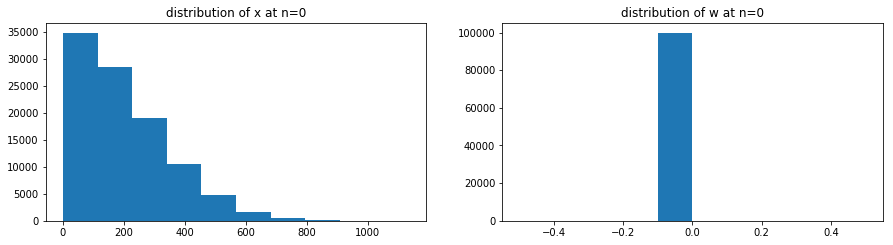

In [187]:
fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(221)
ax.hist(x[0,:])
plt.title("distribution of x at n=0")
ax=fig.add_subplot(222)
ax.hist(w[0,:])
plt.title("distribution of w at n=0")
plt.show()

## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

### 2. Compute $w_n^{j}$ ...